In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import networkx as nx

In [3]:
df = pd.read_excel('../data/Supermarket_Sales_cleaned.xlsx')

In [4]:
df.head()

,ID,Thời gian,Thành phố,Chi nhánh,Nhóm khách hàng,Giới tính,Phân loại,Tên SP,SKU,Giá vốn đơn vị,Giá bán,Số lượng,COGS,Discount,Phương thức thanh toán,Doanh thu ròng,Lợi nhuận
0,CUS-0007,2024-01-01 20:34:00,Đà Nẵng,ABC Hải Châu,Member,Male,Electronics,Laptop,1000,54130.33,70369.43,1,54130.33,0.00,E-Wallet,70369.43,16239.10
1,CUS-0042,2024-01-18 20:04:00,TP.HCM,ABC Thủ Đức,Normal,Female,Electronics,Laptop,1000,54130.33,70369.43,3,162390.99,8592.11,Cash,202516.18,40125.19
2,CUS-0120,2024-01-20 20:05:00,Hà Nội,ABC Cầu Giấy,Normal,Male,Electronics,Laptop,1000,54130.33,70369.43,2,108260.66,3082.18,E-Wallet,137656.68,29396.02
3,CUS-0080,2024-03-09 17:04:00,Đà Nẵng,ABC Hải Châu,Member,Male,Electronics,Laptop,1000,54130.33,70369.43,3,162390.99,18176.42,E-Wallet,192931.87,30540.88
4,CUS-0005,2024-03-30 18:03:00,TP.HCM,ABC Quận 7,Member,Female,Electronics,Laptop,1000,54130.33,70369.43,2,108260.66,3419.95,Credit Card,137318.91,29058.25


### Phân tích mua sắm theo loại sản phẩm

In [5]:
df['Thời gian'] = pd.to_datetime(df['Thời gian'])
df['Giờ mua'] = df['Thời gian'].dt.floor('H')

pairs = []

for time, group in df.groupby('Giờ mua'):
    items = list(group['Phân loại'].unique())
    if len(items) > 1:
        for combo in itertools.combinations(items, 2):
            pairs.append(tuple(sorted(combo)))

pair_df = pd.DataFrame(pairs, columns=['A', 'B'])

co_matrix = pair_df.value_counts().reset_index(name='Tần suất')
heatmap_matrix = co_matrix.pivot(index='A', columns='B', values='Tần suất').fillna(0)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2088\2414057136.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Giờ mua'] = df['Thời gian'].dt.floor('H')


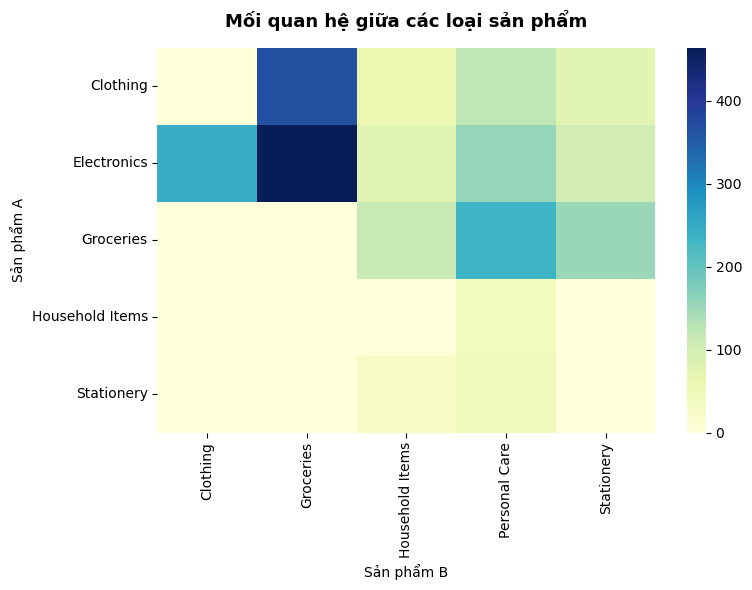

In [6]:
pairs = []
for time, group in df.groupby('Giờ mua'):
    items = list(group['Phân loại'].unique())
    for combo in itertools.combinations(items, 2):
        pairs.append(combo)

pair_df = pd.DataFrame(pairs, columns=['A', 'B'])

# Đếm số lần mỗi cặp xuất hiện
co_matrix = pair_df.value_counts().unstack(fill_value=0)

plt.figure(figsize=(8,6))
sns.heatmap(co_matrix, cmap="YlGnBu", annot=False)
plt.title("Mối quan hệ giữa các loại sản phẩm", fontsize=13, fontweight='bold', pad=15)
plt.xlabel("Sản phẩm B")
plt.ylabel("Sản phẩm A")
plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_2088\3938780410.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


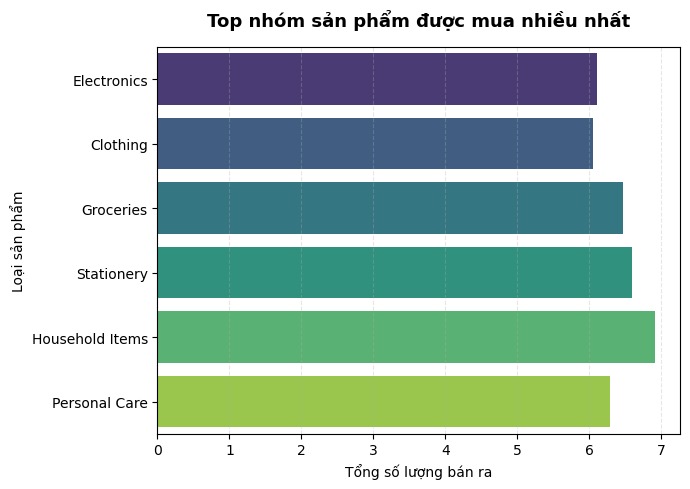

In [7]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=df,
    y='Phân loại',
    x='Số lượng',
    palette='viridis',
    edgecolor=None,
    linewidth=0, 
     errorbar=None 
)

plt.title("Top nhóm sản phẩm được mua nhiều nhất", fontsize=13, fontweight='bold', pad=15)
plt.xlabel("Tổng số lượng bán ra")
plt.ylabel("Loại sản phẩm")
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


### Phân tích sản phẩm có doanh thu và lợi nhuận cao nhất

Doanh thu theo sản phẩm

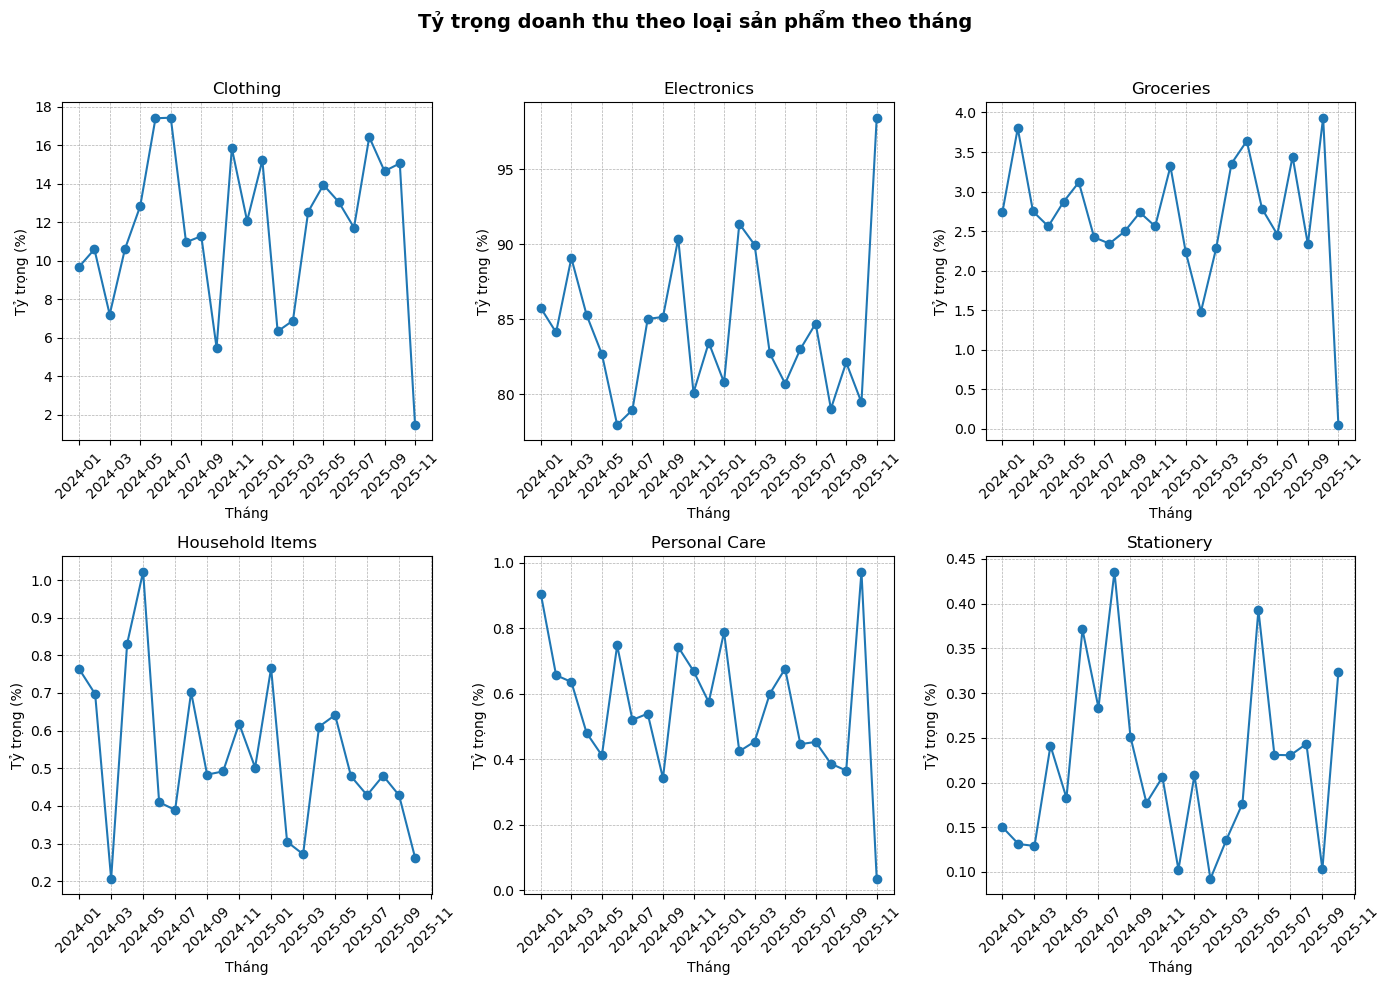

In [8]:

df['Thời gian'] = pd.to_datetime(df['Thời gian'], dayfirst=True)

df['Month'] = df['Thời gian'].dt.strftime('%Y-%m')
df = df.sort_values('Thời gian')

monthly_sales = df.groupby(['Month', 'Phân loại'])['Doanh thu ròng'].sum().reset_index()

total_monthly = monthly_sales.groupby('Month')['Doanh thu ròng'].sum().reset_index()
monthly_sales = monthly_sales.merge(total_monthly, on='Month', suffixes=('', '_Total'))

monthly_sales['Ratio (%)'] = monthly_sales['Doanh thu ròng'] / monthly_sales['Doanh thu ròng_Total'] * 100

product_categories = monthly_sales['Phân loại'].unique()

plt.figure(figsize=(14, 10))
plt.suptitle("Tỷ trọng doanh thu theo loại sản phẩm theo tháng", fontsize=14, fontweight='bold')

unique_months = df['Month'].unique()  
for i, category in enumerate(product_categories, 1):
    plt.subplot(2, 3, i)
    
    data = monthly_sales[monthly_sales['Phân loại'] == category]
    data = data.set_index('Month').reindex(unique_months).reset_index()

    ax = plt.gca()  
    plt.plot(data['Month'], data['Ratio (%)'], marker='o')
    plt.title(category)
    plt.xlabel("Tháng")
    plt.ylabel("Tỷ trọng (%)")
    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.xticks(rotation=45)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2]) 

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Lợi nhuận theo nhóm sản phẩm

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2088\3275956772.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


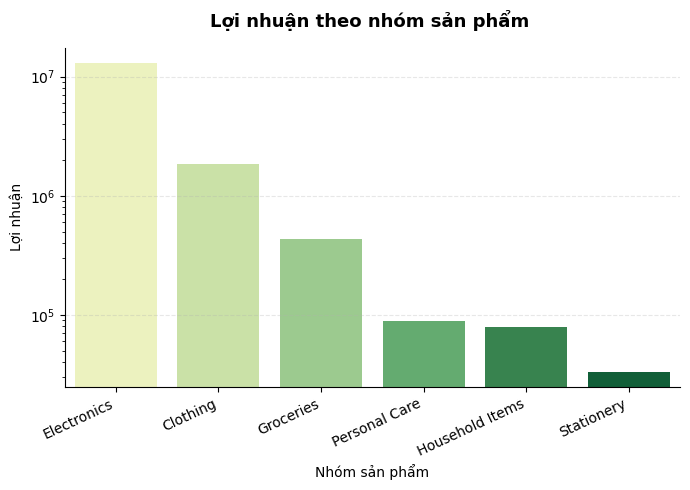

In [9]:
df_profit_group = (
    df.groupby('Phân loại')['Lợi nhuận']
    .sum()
    .reset_index()
    .sort_values('Lợi nhuận', ascending=False)
)
plt.figure(figsize=(7,5))
sns.barplot(
    data=df_profit_group,
    x='Phân loại',
    y='Lợi nhuận',
    palette='YlGn',
    edgecolor='none'
)

plt.yscale('log') 
plt.title("Lợi nhuận theo nhóm sản phẩm ", fontsize=13, fontweight='bold', pad=15)
plt.xlabel("Nhóm sản phẩm")
plt.ylabel("Lợi nhuận")
plt.xticks(rotation=25, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


### Phân tích xu hướng chọn loại sản phẩm theo giới tính

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2088\3110791251.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bars = sns.barplot(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2088\3110791251.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


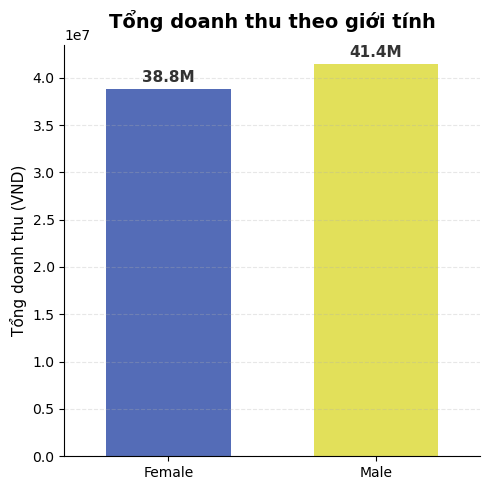

In [10]:
df_gender_rev = df.groupby("Giới tính")["Doanh thu ròng"].sum().reset_index()

plt.figure(figsize=(5,5))
palette = ["#4364C8FF", "#F9F643FF"]  # Xanh navy nhạt & cam pastel

bars = sns.barplot(
    x='Giới tính', 
    y='Doanh thu ròng', 
    data=df_gender_rev, 
    palette=palette, 
    ci=None,
    width=0.6
)
plt.title('Tổng doanh thu theo giới tính', fontsize=14, fontweight='bold', pad=12)
plt.xlabel('')
plt.ylabel('Tổng doanh thu (VND)', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in bars.patches:
    value = p.get_height()
    plt.text(
        p.get_x() + p.get_width()/2, value + value*0.01,
        f"{value/1e6:,.1f}M", ha='center', va='bottom',
        fontsize=11, fontweight='bold', color='#333333'
    )

sns.despine()
plt.tight_layout()
plt.show()


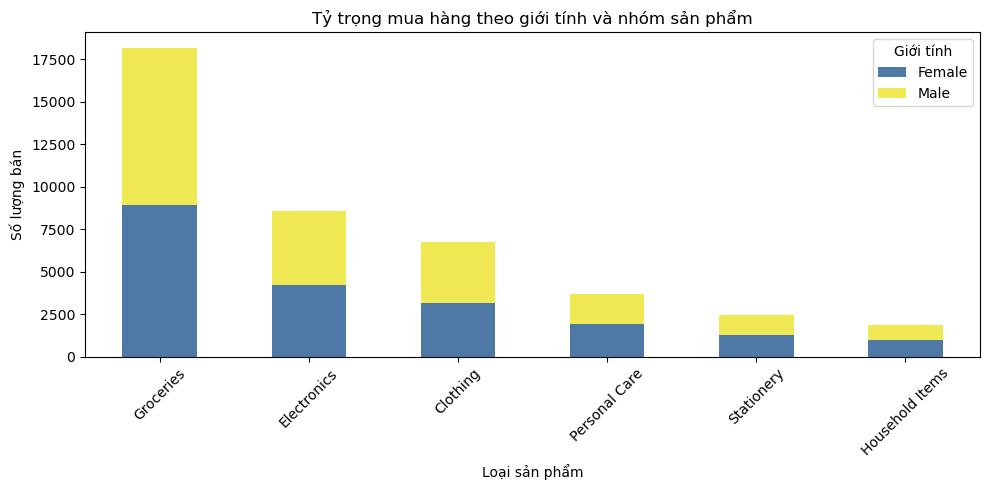

In [11]:
# Gom số lượng bán theo giới tính và loại sản phẩm
category_gender = df.groupby(['Phân loại', 'Giới tính'])['Số lượng'].sum().unstack().fillna(0)

# Sắp xếp theo tổng số lượng giảm dần
category_gender = category_gender.loc[category_gender.sum(axis=1).sort_values(ascending=False).index]

# Vẽ stacked bar
category_gender.plot(kind='bar', stacked=True, figsize=(10,5),
                     color=['#4E79A7', "#F1E954"])
plt.title("Tỷ trọng mua hàng theo giới tính và nhóm sản phẩm")
plt.xlabel("Loại sản phẩm")
plt.ylabel("Số lượng bán")
plt.legend(title="Giới tính")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Phân tích xu hướng chọn loại sản phẩm theo nhóm khách hàng

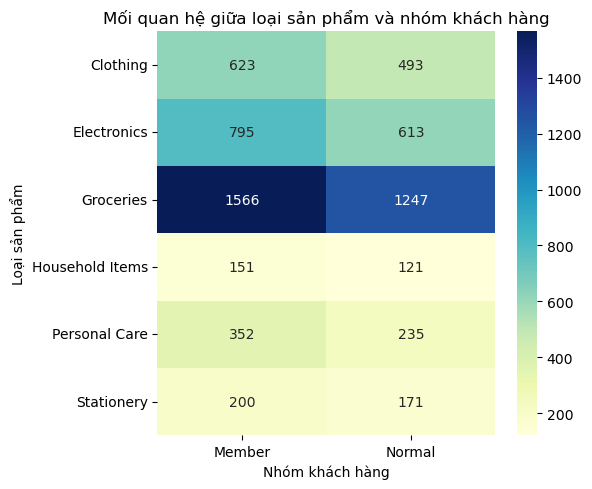

In [12]:
pivot = df.pivot_table(
    values='Số lượng', 
    index='Phân loại', 
    columns='Nhóm khách hàng', 
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".0f")
plt.title("Mối quan hệ giữa loại sản phẩm và nhóm khách hàng")
plt.xlabel("Nhóm khách hàng")
plt.ylabel("Loại sản phẩm")
plt.tight_layout()
plt.show()


In [13]:
df1 = pd.read_excel("Customer_dataset.xlsx")

FileNotFoundError: [Errno 2] No such file or directory: 'Customer_dataset.xlsx'

In [ ]:
df1.head()

,Unnamed: 0,ID,Tần_suất_mua_hàng,Tổng_doanh_thu,Doanh_thu_trung_bình,Tổng_số_lượng_SP,Số_lượng_SP_trung_bình,Tổng_tiền_giảm_giá,Tỷ_lệ_giảm_giá_trung_bình,Giới_tính,Thành_phố,Nhóm_khách_hàng,Sản_phẩm_ưa_thích,PLoai_Sản_phẩm_ưa_thích,PTTT_ưa_thích,Chi_nhánh_ưa_thích,Recency
0,0,CUS-0001,85,1326331.32,15603.897882,587,6.905882,49309.04,580.106353,Female,Hà Nội,Member,Monitor,Groceries,E-Wallet,ABC Thanh Xuân,36
1,1,CUS-0002,7,167135.06,23876.437143,45,6.428571,93.38,13.340000,Male,TP.HCM,Normal,Coffee (200g),Groceries,E-Wallet,ABC Quận 7,454
2,2,CUS-0003,3,200530.06,66843.353333,22,7.333333,14238.61,4746.203333,Male,TP.HCM,Normal,Bluetooth Speaker,Electronics,E-Wallet,ABC Quận 1,631
3,3,CUS-0004,5,58612.86,11722.572000,23,4.600000,610.90,122.180000,Female,Hà Nội,Normal,Bread,Groceries,Cash,ABC Hoàn Kiếm,630
4,4,CUS-0005,101,921013.33,9118.943861,628,6.217822,59609.56,590.193663,Female,TP.HCM,Member,Wheat Flour,Groceries,E-Wallet,ABC Quận 1,14


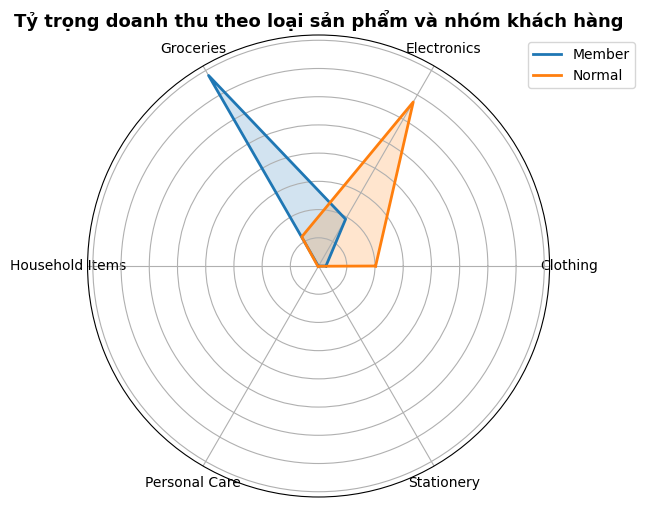

In [ ]:
rev = df1.groupby(["Nhóm_khách_hàng","PLoai_Sản_phẩm_ưa_thích"])["Tổng_doanh_thu"].sum().unstack()
rev_percent = rev.div(rev.sum(axis=1), axis=0) * 100  # chuẩn hóa theo %

# radar chart
categories = list(rev_percent.columns)
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for idx, row in rev_percent.iterrows():
    values = row.tolist() + [row.tolist()[0]]
    ax.plot(angles, values, label=idx, linewidth=2)
    ax.fill(angles, values, alpha=0.2)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title("Tỷ trọng doanh thu theo loại sản phẩm và nhóm khách hàng", fontsize=13, fontweight="bold")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1))
plt.show()


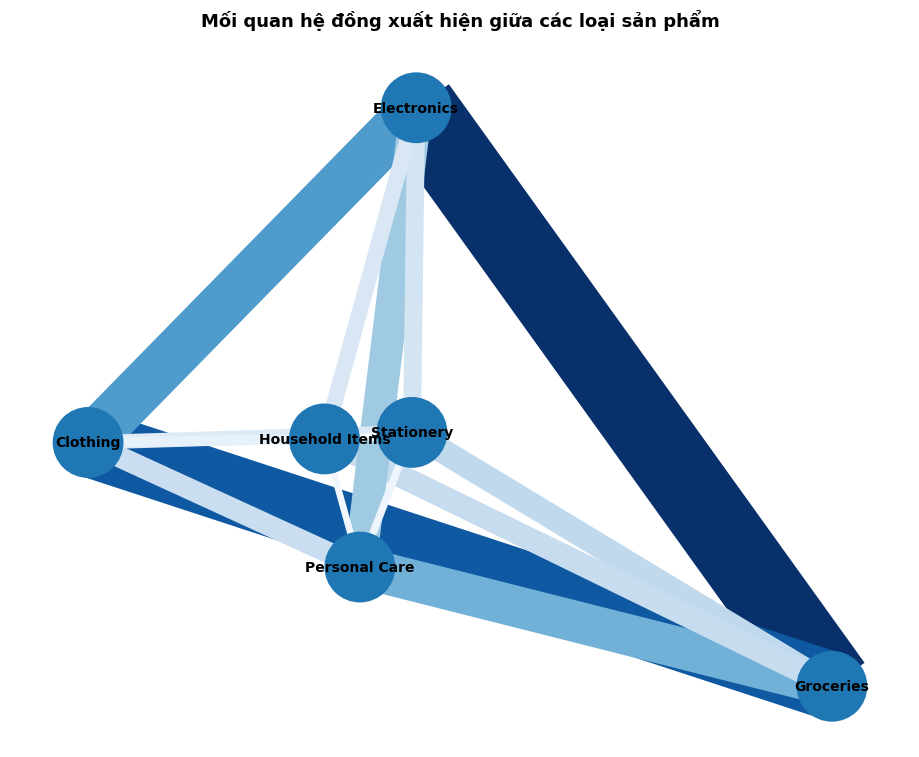

In [ ]:
# Network graph
G = nx.Graph()

for _, row in pair_count.iterrows():
    G.add_edge(row['Sản phẩm A'], row['Sản phẩm B'], weight=row['Tần suất'])

node_size = [G.degree(n) * 400 for n in G.nodes()]
edge_weights = [d['weight'] for (_, _, d) in G.edges(data=True)]
edge_width = [w * 0.3 for w in edge_weights]
node_size = [G.degree(n) * 500 for n in G.nodes()]

pos = nx.kamada_kawai_layout(G) 

plt.figure(figsize=(9,7))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    edge_color=edge_weights,
    edge_cmap=plt.cm.Blues,
    width=edge_width,
    node_size=node_size,
    font_size=10,
    font_weight='bold'
)

plt.title("Mối quan hệ đồng xuất hiện giữa các loại sản phẩm", fontsize=13, fontweight='bold', pad=15)
plt.axis('off')
plt.show()